# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [51]:
%matplotlib inline
import nbresuse
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



In [52]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [53]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [54]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [55]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [56]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [57]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [58]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [59]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [60]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [61]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [62]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [63]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [64]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [65]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [66]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [67]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [68]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [69]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [70]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [71]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [72]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:10<00:00, 459.26it/s]


In [73]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [74]:
## Similarly doing preprocessing for reviews summary

#printing some random values of summary

summ_0 = final["Summary"].values[0]
print(summ_0)

summ_1500 = final["Summary"].values[1500]
print(summ_1500)

thirty bucks?
Are We Reviewing Our Mistakes Or These Cookies?


In [75]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#removing urls
#removing all html tags
#contracting words 
#removing words with number
#removing words with special character
preprocessed_reviews_summary = []

from tqdm import tqdm
for summary in tqdm(final["Summary"].values):
    summary = re.sub(r"http\S+", "" ,summary)
    summary = BeautifulSoup(summary,"lxml").get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(summary.strip())
    

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:06<00:00, 765.45it/s]


## Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [76]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import math as m

In [77]:
final.shape

(4986, 10)

In [78]:
final["cleaned_text"] = preprocessed_reviews
print(final.shape)
final.head()



(4986, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...


In [79]:
print(final["Score"].value_counts())

1    4178
0     808
Name: Score, dtype: int64


We can conclude that dataset is imbalanced. We have to balance it using any methods(undersampling,oversampling,etc) for better working of our model.

In [80]:
#Randomly taking 40000 points from each positive and negative reviews due to time and space complexity.
data_pos = final[final["Score"] ==1.0].sample(n=800)
data_neg = final[final["Score"] ==0.0].sample(n=800)
data_pos.head()

#concatenating the positive and negative reviews data 
final_cleaned_data = pd.concat([data_pos,data_neg],axis=0)

print(final_cleaned_data.shape)
final_cleaned_data.head()


(1600, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
3664,3981,B008EMA3AS,A199USG4MU1NWI,rtb521,0,0,1,1350000000,Awesome sauce!,I absolutely love this product! I use it on c...,absolutely love product use chicken beef veggi...
1293,1397,B00068PCTU,A2LUSYXY8NXYKW,KareeGirl,0,0,1,1325116800,Best taste ever!,I discovered this product a couple of years ag...,discovered product couple years ago really lik...
1008,1093,B0025ULYKI,A2MZ43MMIBFL7M,John,5,5,1,1260921600,"Great Taste, Okay Crunch",I first had these Uncle Ray's chips a few year...,first uncle ray chips years ago traveling west...
4637,5035,B001EO6BCM,A3MPJUO2SA3TUM,Joyce,0,0,1,1325203200,Christmas shopping,I've tried many different brands of Virginia p...,tried many different brands virginia peanuts f...
1996,2178,B002SW7ZOW,A2CIIHVCG2FXSP,"YLuvAmazon ""YLuvAmazon""",2,2,1,1268265600,Fine Quality Tea!,I love this TEA. It has a very smooth taste an...,love tea smooth taste not bitter like kind tea...


In [32]:
#time based splitting of the data
#converting time to date and time
final_cleaned_data["Time"] = pd.to_datetime(final_cleaned_data["Time"],unit="s")
final_cleaned_data = final_cleaned_data.sort_values(by = "Time")
final_cleaned_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1173,1273,B000WNJ73Q,A22A7OEB664QSC,Kathleen Stept,3,3,1,2004-08-18,"Healthy, non-fattening, just the right size an...",I've been feeding liver biscotti for years. I ...,feeding liver biscotti years looking healthy t...
1193,1293,B000WNJ73Q,AE5DR1HZNY9CV,Rich Wyzykoski,0,0,1,2005-01-23,Rich J Wyzykoski,"A fantastic product for pet treats,great smell...",fantastic product pet treats great smell freez...
2106,2296,B0001VWE02,AQM74O8Z4FMS0,Sunshine,0,0,0,2005-09-25,Below standard,Too much of the white pith on this orange peel...,much white pith orange peel making product ove...
2721,2963,B0005YYHQY,A2MWRKME57F53V,Science Geek,7,8,1,2005-10-28,Superlative store bought cookies: very hard to...,Buy these cookies. You will not regret it.<br ...,buy cookies not regret hands best store bought...


In [33]:
X = np.array(final_cleaned_data.loc[:,["cleaned_text"]])
Y = np.array(final_cleaned_data.loc[:,["Score"]])

#splitting the data into train and test.
X_train,x_test,Y_train,y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state= 42)

x_train , x_cv,y_train,y_cv = model_selection.train_test_split(X_train,Y_train,test_size =0.3,random_state = 42)



In [34]:
#converting all into dataframes 
X_train = pd.DataFrame(X_train,columns = ["text"])
x_train = pd.DataFrame(x_train,columns = ["text"])
x_cv = pd.DataFrame(x_cv,columns =["text"])
x_test = pd.DataFrame(x_test,columns =["text"])


# Initialising the BOW vector representation
count_vec = CountVectorizer()
count_vec.fit(x_train["text"])
X_train_bow = count_vec.transform(X_train["text"])
x_train_bow = count_vec.transform(x_train["text"])
x_cv_bow = count_vec.transform(x_cv["text"])
x_test_bow = count_vec.transform(x_test["text"])


In [35]:
print(len(count_vec.get_feature_names()))
print(X_train_bow[1].toarray())

5485
[[0 0 0 ... 0 0 0]]


### Hyperparameter Tuning :- <FONT COLOR="RED">GRID SEARCH CV

In [36]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range_l2 = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range_l2)
clf=GridSearchCV(LogisticRegression(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
#The Roc_Auc Value is calculated using method of thresholds, TPR,FPR.

clf.fit(x_train_bow,y_train)
probcv=clf.predict_proba(x_cv_bow)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_bow)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c=clf.best_params_['C']
print("The best c value is ",best_c)

The best c value is  1


[0.79394428 0.83833995 0.85782465 0.85998497 0.85679788]
For C_value(Lambda)= 0.7939442805805141 mean test score is 0.001
For C_value(Lambda)= 0.8383399483546615 mean test score is 0.01
For C_value(Lambda)= 0.8578246540398012 mean test score is 0.1
For C_value(Lambda)= 0.8599849687887864 mean test score is 1
For C_value(Lambda)= 0.856797875617805 mean test score is 10


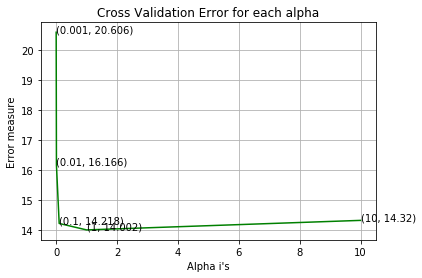

In [37]:
#plotting error plot
mean_test_score = clf.cv_results_['mean_test_score']
print(mean_test_score)
for i in range(len(mean_test_score)):
    print("For C_value(Lambda)= {0} mean test score is {1}".format(mean_test_score[i],C_range_l2[i]))
    
error = [(1-i)*100 for i in mean_test_score]
fig, ax = plt.subplots()
ax.plot(C_range_l2, error,c='g')
for i, txt in enumerate(np.round(error,3)):
    ax.annotate((C_range_l2[i],np.round(txt,3)), (C_range_l2[i],error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## L2 regularizer ON BOW

In [38]:
#training and fiiting the model
bow_model_l2 = LogisticRegression(penalty ='l2',C = 0.1,random_state = 42)
bow_model_l2.fit(X_train_bow,Y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color="red"> PERFORMANCE METRICS

In [39]:
pred_bow_l2 = bow_model_l2.predict(x_test_bow)
#train test accuracy
train_acc_bow_l2 = bow_model_l2.score(X_train_bow,Y_train.ravel())
test_acc_bow_l2 = bow_model_l2.score(x_test_bow,y_test)

#train test ROC value
y_scores_bow_train = bow_model_l2.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_bow_l2 = auc(fpr,tpr)

y_scores_bow_test = bow_model_l2.predict_proba(x_test_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_bow_l2= auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_bow_l2 = precision_score(y_test, pred_bow_l2) * 100
rec_bow_l2 = recall_score(y_test, pred_bow_l2) * 100
f1_bow_l2 = f1_score(y_test, pred_bow_l2) * 100


print("\nTrain accuracy=%f%%"% (train_acc_bow_l2*100))
print("\nTest accuracy=%e%% "% (test_acc_bow_l2*100))
print("\nTrain ROC value=%f"% (roc_auc_train_bow_l2))
print("\nTest ROC value=%f"% (roc_auc_test_bow_l2))
print('\nprecision=%f%%' % (pre_bow_l2))
print('\nrecall=%f%%' % (rec_bow_l2))
print('\nF1-Score=%f%%' % (f1_bow_l2))




Train accuracy=96.250000%

Test accuracy=8.166667e+01% 

Train ROC value=0.995299

Test ROC value=0.891029

precision=81.027668%

recall=83.673469%

F1-Score=82.329317%


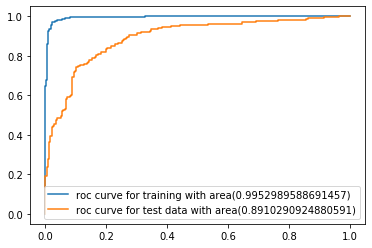

In [40]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_bow_l2))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_bow_l2))
plt.legend(loc="lower right")
plt.show()

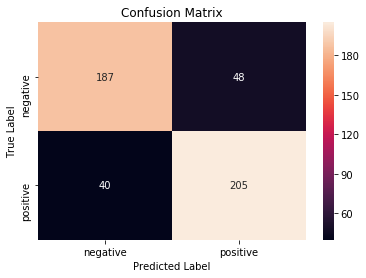

In [41]:

cm_bow = confusion_matrix(y_test,pred_bow_l2)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Using l1 Regularizer

### HYPERPARAMETER TUNING: <font color = "red">GRIDSEARCH CV

In [42]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range_l1 = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range_l1)
clf_1=GridSearchCV(LogisticRegression(penalty ='l1'),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf_1.fit(x_train_bow,y_train)
probcv=clf.predict_proba(x_cv_bow)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_bow)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c1=clf.best_params_['C']
print("The best c value is ",best_c1)

The best c value is  1


[0.79394428 0.83833995 0.85782465 0.85998497 0.85679788]
For C_value(Lambda)= 0.7939442805805141 mean test score is 0.001
For C_value(Lambda)= 0.8383399483546615 mean test score is 0.01
For C_value(Lambda)= 0.8578246540398012 mean test score is 0.1
For C_value(Lambda)= 0.8599849687887864 mean test score is 1
For C_value(Lambda)= 0.856797875617805 mean test score is 10


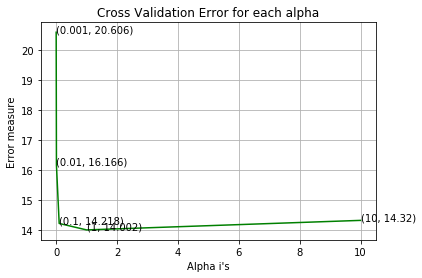

In [43]:
#plotting error plot
mean_test_score = clf.cv_results_['mean_test_score']
print(mean_test_score)
for i in range(len(mean_test_score)):
    print("For C_value(Lambda)= {0} mean test score is {1}".format(mean_test_score[i],C_range_l1[i]))
    
error = [(1-i)*100 for i in mean_test_score]
fig, ax = plt.subplots()
ax.plot(C_range_l1, error,c='g')
for i, txt in enumerate(np.round(error,3)):
    ax.annotate((C_range_l1[i],np.round(txt,3)), (C_range_l1[i],error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [44]:
#Training and testing the model with obtained value of C values
bow_model_l1 = LogisticRegression(penalty ='l1',C = 0.1,random_state = 42)
bow_model_l1.fit(X_train_bow,Y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
pred_bow_l1 = bow_model_l1.predict(x_test_bow)
#train test accuracy
train_acc_bow_l1 = bow_model_l1.score(X_train_bow,Y_train.ravel())
test_acc_bow_l1 = bow_model_l1.score(x_test_bow,y_test)

#train test ROC value
y_scores_bow_train_l1 = bow_model_l1.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_bow_l1 = auc(fpr,tpr)

y_scores_bow_test = bow_model_l1.predict_proba(x_test_bow)
fpr_l1,tpr_l1,thresholds = roc_curve(y_test,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_bow_l1 = auc(fpr_l1,tpr_l1)

#Precision , recall and fl1_score 
pre_bow_l1 = precision_score(y_test, pred_bow_l1) * 100
rec_bow_l1 = recall_score(y_test, pred_bow_l1) * 100
fl_bow_l1 = f1_score(y_test, pred_bow_l1) * 100


print("\nTrain accuracy=%f%%"% (test_acc_bow_l1*100))
print("\nTest accuracy=%e%% "% (test_acc_bow_l1*100))
print("\nTrain ROC value=%f%%"% (roc_auc_train_bow_l1))
print("\nTest ROC value=%f%%"% (roc_auc_test_bow_l1))
print('\nprecision=%f%%' % (pre_bow_l1))
print('\nrecall=%f%%' % (rec_bow_l1))
print('\nFl1-Score=%f%%' % (fl_bow_l1))




Train accuracy=76.250000%

Test accuracy=7.625000e+01% 

Train ROC value=0.995299%

Test ROC value=0.821607%

precision=78.854626%

recall=73.061224%

Fl1-Score=75.847458%


In [46]:
#Confusion Matrix
  
from sklearn.metrics import confusion_matrix
cm_bow_l1 = confusion_matrix(y_test, pred_bow_l1)
cm_bow_l1

array([[187,  48],
       [ 66, 179]], dtype=int64)

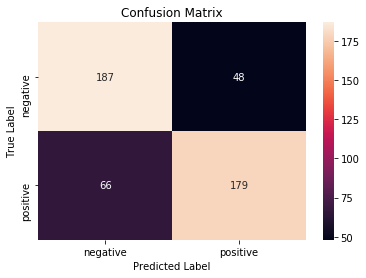

In [47]:
cm_bow_l1 = confusion_matrix(y_test,pred_bow_l1)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow_l1, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [48]:
#Calculating sparsity
w = bow_model_l1.coef_[0]
sparsity = np.count_nonzero(w)
print(sparsity)
print(len(w))

43
5485


ModuleNotFoundError: No module named 'resource'

### OBSERVATION:

The sparsity value is 560.(i.e number of non zero features is only 327 out of ).The advantage of using l1 regularizer is , it convert non-important features into zero vector.)

# PERTUBATION TEST

This test is to check whether the features are collinear or not. 
#### CONCEPT : If the median value of percentage change vector is high implies that features are collinear otherwise non collinear. if non-collinear then weight vectors can be used to get the top features.

In [1]:
pre_w = bow_model_l2.coef_[0]
pre_w += 10**-6

X_train_bow = X_train_bow.toarray()
X_train_bow = X_train_bow.astype(float)
noise_data = X_train_bow
noise_data +=0.01

clf = LogisticRegression(C = best_c)
clf.fit(noise_data,Y_train)

new_w = clf.coef_[0]
new_w +=10**-6




NameError: name 'bow_model_l2' is not defined

In [49]:
#finding the change in percentage value 
def Weight_change(Pre_weights,New_weights):
    per_cng=[]
    for i in range(len(pre_w)):
        per = a[i]*100/pre_w[i]
        per_cng.append(per)
    return per_cng
    
# to calculate percentage change for both weights
a = new_w - pre_w  
per_change = Weight_change(pre_w,new_w)

In [50]:
import math as m
per_change = abs(np.array(per_change))
print(np.median(per_change))

73.403766833797


The median value of the percentage change vector is 0.46% i.e: the value is very less implying that the features are NON COLLINEAR

[ 99.1  99.2  99.3  99.4  99.5  99.6  99.7  99.8  99.9 100. ]
[9300.302222808887, 10568.371246496665, 11309.332783409967, 12265.418309122977, 13424.457053127006, 14364.419893018436, 16474.7777076888, 31027.60160842448, 91385.3480749347, 689926.3954904546]


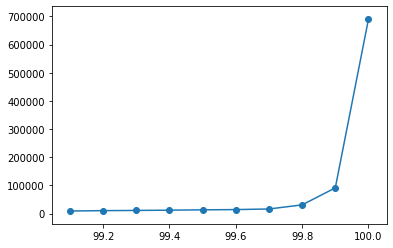

In [51]:
per_change = np.array(per_change)
percentiles = []
a = np.arange(99.1,100.0,0.1)
print(a)
for i in a:
    b=np.percentile(per_change,i)
    percentiles.append(b)
print(percentiles)    
plt.plot(a,np.array(percentiles))    
plt.scatter(a,np.array(percentiles))   
plt.show()

####  The features are non collinear. Hence, the feature importance can be obtained using the weight vectors 

In [52]:
#extracting all features name obtained from BOW count vectorizer.
f = count_vec.get_feature_names()
f = np.array(f)
print(f.shape)

#extracting coefficients from logistic regression model(i.e - The values of w and b)
cof = bow_model.coef_[0]
cof= np.array(cof)
cof.shape
cof = cof.T
cof.shape

##creating a dataframe for features and it's corresponding weight vector
weight_vector = pd.DataFrame({'weight':cof,'feature':f})
weight_vector.head()

(17611,)


,weight,feature
0,-0.161610,aa
1,0.019624,aaa
2,-0.027124,aachen
3,0.003631,aadp
4,0.103684,aamazon


#### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [53]:
# to get top 20 positive and negative features 
weight_vector = weight_vector.sort_values("weight", axis = 0 ,ascending = False, kind = 'quicksort',na_position = 'last')
weight_vector.head()

,weight,feature
17334,2.142878,wonderful
5368,2.097212,excellent
4052,1.998955,delicious
5350,1.835145,exactly
500,1.810816,amazing


In [54]:
print(weight_vector.head(20).to_string(index = False))

   weight     feature
 2.142878   wonderful
 2.097212   excellent
 1.998955   delicious
 1.835145     exactly
 1.810816     amazing
 1.759537     pleased
 1.666253      highly
 1.638550     perfect
 1.623569      smooth
 1.579115        best
 1.572880        beat
 1.549943       yummy
 1.537010      slight
 1.505903        nice
 1.495546   beautiful
 1.466568       great
 1.367348   fantastic
 1.337546     overall
 1.327257        coat
 1.318571  affordable


#### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [55]:
print(weight_vector.tail(20).to_string(index = False))

   weight         feature
-1.434352           threw
-1.460758          caused
-1.534957           shame
-1.540206    disappointed
-1.562984           stick
-1.579504           bland
-1.586722           nasty
-1.631386           awful
-1.643334            weak
-1.663272   unfortunately
-1.694105      disgusting
-1.712684          return
-1.796873         pricing
-1.841476        terrible
-1.906638        horrible
-2.000301  disappointment
-2.018719           trash
-2.333895           worst
-2.394414   disappointing
-2.408162             rip


## Pretty table 

In [56]:
from prettytable import PrettyTable
x = PrettyTable()

reg1 = 'L1'
reg2 = 'L2'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]


err1_train = np.around(100 - train_acc_bow1*100 , decimals = 2)
err1_test =  np.around(100 - test_acc_bow1*100 , decimals = 2)
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)


err2_train = np.around(100 - train_acc_bow2*100, decimals = 2)
err2_test =  np.around(100 - test_acc_bow2*100, decimals = 2)
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,best_c,err1_train,err1_test,pre1,rec1,f11])
x.add_row([cv,reg2,best_c,err2_train,err2_test,pre2,rec2,f12])

print(x)

+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
| Grid |      L1     |   0.1   |      4.63      |     14.56     |    85.32     |   85.28   |     85.3    |
| Grid |      L2     |   0.1   |      1.86      |     14.33     |    85.48     |   85.59   |    85.53    |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+


The test error obtained is high as compared to train error. Even the test error is high but it's not too high , Hence this model is sensible for classification.

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [57]:
final.shape


(87773, 11)

In [58]:
#using cleaned data we did in BOW 
final_cleaned_data.shape

(15000, 11)

In [59]:
#splitting the data into train and test
X_tfidf = np.array(final_cleaned_data.loc[:,["cleaned_text"]])
Y_tfidf = np.array(final_cleaned_data.loc[:,["Score"]])
X_train,x_test,Y_train,y_test = model_selection.train_test_split(X_tfidf,Y_tfidf,test_size = 0.3,random_state= 42)
x_train , x_cv,y_train,y_cv = model_selection.train_test_split(X_train,Y_train,test_size =0.3,random_state = 42)


In [69]:
#converting all into dataframes 
X_train = pd.DataFrame(X_train,columns = ["text"])
x_train = pd.DataFrame(x_train,columns = ["text"])
x_cv = pd.DataFrame(x_cv,columns =["text"])
x_test = pd.DataFrame(x_test,columns =["text"])

# Initialising the TFIDF vetorizer
tfidf_vec = TfidfVectorizer(min_df = 10,ngram_range =(1,2))
tfidf_vec.fit(X_train["text"])
X_train_tfidf = tfidf_vec.transform(X_train["text"])
x_train_tfidf = tfidf_vec.transform(x_train["text"])
x_cv_tfidf = tfidf_vec.transform(x_cv["text"])
x_test_tfidf = tfidf_vec.transform(x_test["text"])
#X_train = count_vec.transform(X_train["text"])
print(x_train_tfidf.shape)
print(y_train.shape)

(7350, 6628)
(7350, 1)


#### HYPERPARAMETER TUNING: <FONT COLOR="RED"> GRIDSEARCHCV

In [70]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range)
clf=GridSearchCV(LogisticRegression(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_tfidf,y_train)
probcv=clf.predict_proba(x_cv_tfidf)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_tfidf)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c=clf.best_params_['C']
print("The best c value is ",best_c)

The best c value is  10


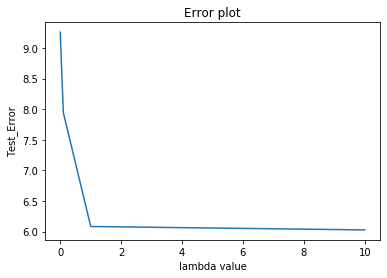

In [71]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in clf.cv_results_['mean_test_score']]
plt.plot(C_range, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [72]:
#fitting the model
tfidf_model = LogisticRegression(penalty ='l2',C = 10,random_state = 42)
tfidf_model.fit(X_train_tfidf,Y_train)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### <FONT COLOR="RED"> PERFORMANCE METRICS

In [73]:
pred_tfidf = tfidf_model.predict(x_test_tfidf)

#train test accuracy
train_acc_tfidf2 = tfidf_model.score(X_train_tfidf,Y_train.ravel())
test_acc_tfidf2 = tfidf_model.score(x_test_tfidf,y_test)

#train test ROC value
y_scores_tfidf_train = tfidf_model.predict_proba(x_train_tfidf)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr,tpr)

y_scores_tfidf_test = tfidf_model.predict_proba(x_test_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre2 = precision_score(y_test, pred_tfidf) * 100
rec2 = recall_score(y_test, pred_tfidf) * 100
f12 = f1_score(y_test, pred_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf2*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf2*100))
print("\nTrain ROC value=%f"% (roc_auc))
print("\nTest ROC value=%f"% (roc_auc_1))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))




Train accuracy=97.723810%

Test accuracy=8.813333e+01% 

Train ROC value=0.950702

Test ROC value=0.922319

precision=88.187556%

recall=87.791741%

F1-Score=87.989204%


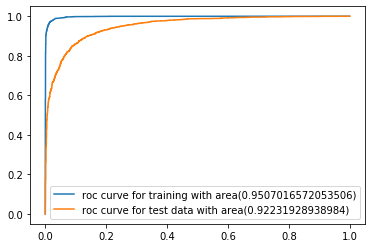

In [74]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_1))
plt.legend(loc="lower right")
plt.show()

In [75]:
 #Confusion Matrix
pred_tfidf = tfidf_model.predict(x_test_tfidf)    
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
cm_tfidf

array([[2010,  262],
       [ 272, 1956]], dtype=int64)

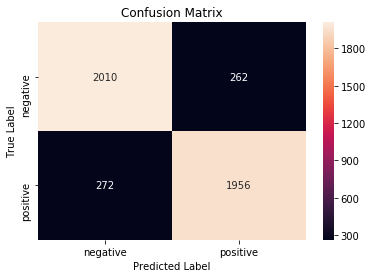

In [76]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### OBSERVATIONS:
1. The TPR and TNR value is high as compared to FPR and FNR value.<br>
2. The ROC value for test data is greater than 0.5 (i.e 0.85). Hence, our model is sensible and good for classification.
3. The Precision, Recall and F_1 score is high. Hence, model is predicting more correct responses.

### PERBUTAION TEST FOR TFIDF

This test is to check whether the features are collinear or not. 
#### CONCEPT : If the median value of percentage change vector is high implies that features are collinear otherwise non collinear. if non-collinear then weight vectors can be used to get the top features.

### <FONT COLOR="RED"> Gridsearchcv

In [77]:
pre_w = tfidf_model.coef_[0]
pre_w += 10**-6

X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf = X_train_tfidf.astype(float)
noise_data = X_train_tfidf
noise_data +=0.01

clf = LogisticRegression(C = best_c)
clf.fit(noise_data,Y_train)

new_w = clf.coef_[0]
new_w +=10**-6



In [78]:
#finding the change in percentage value 
def Weight_change(Pre_weights,New_weights):
    per_cng=[]
    for i in range(len(pre_w)):
        per = a[i]*100/pre_w[i]
        per_cng.append(per)
    return per_cng
    
# to calculate percentage change for both weights
a = new_w - pre_w  
per_change = Weight_change(pre_w,new_w)

In [79]:
import math as m
per_change = abs(np.array(per_change))
print(np.median(per_change))

0.6055080350329358


The median value is low. Hence , the feature are non collinear.

[ 99.1  99.2  99.3  99.4  99.5  99.6  99.7  99.8  99.9 100. ]
[34.03971343854851, 43.42322249506391, 47.50971418296987, 55.75706739887896, 64.43142235822417, 68.67994057978966, 83.09150049656206, 111.1860767830668, 207.03100659155928, 4217.343972233539]


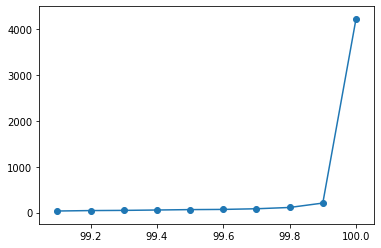

In [80]:
per_change = np.array(per_change)
percentiles = []
a = np.arange(99.1,100.0,0.1)
print(a)
for i in a:
    b=np.percentile(per_change,i)
    percentiles.append(b)
print(percentiles)    
plt.plot(a,np.array(percentiles))    
plt.scatter(a,np.array(percentiles))   
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [81]:
#extracting all features name obtained from tfidf count vectorizer.
f = tfidf_vec.get_feature_names()
f = np.array(f)
print(f.shape)

#extracting coefficients from logistic regression model(i.e - The values of w and b)
cof = tfidf_model.coef_[0]
cof= np.array(cof)
cof.shape
cof = cof.T
cof.shape

##creating a dataframe for features and it's corresponding weight vector
weight_vector = pd.DataFrame({'weight':cof,'feature':f})
weight_vector.head()

(6628,)


,weight,feature
0,-0.155002,ability
1,1.429269,able
2,-0.793825,able eat
3,1.112469,able enjoy
4,1.523293,able find


In [82]:
# to get top 20 positive and negative features 
weight_vector = weight_vector.sort_values("weight", axis = 0 ,ascending = False, kind = 'quicksort',na_position = 'last')
weight_vector.head()

,weight,feature
2444,10.944389,great
1367,10.299934,delicious
420,8.797491,best
6475,8.505665,wonderful
1791,8.488256,excellent


#### Top 10 important features of positive class from<font color='red'> SET 2</font>

In [83]:
# to get top 20 positive and negative features 
print(weight_vector.head(20).to_string(index=False))
#weight_vector.iloc[0:10,0:2]

    weight           feature
 10.944389             great
 10.299934         delicious
  8.797491              best
  8.505665         wonderful
  8.488256         excellent
  8.079078           perfect
  7.932406              good
  7.899415  not disappointed
  7.769914              love
  7.460308              nice
  7.313077             loves
  6.848862           amazing
  6.542765           exactly
  6.453281           pleased
  6.183079             yummy
  6.006350  highly recommend
  5.703808             tasty
  5.614015            smooth
  5.440910          favorite
  5.400462            highly


#### Top 10 important features of negative class from<font color='red'> SET 2</font>

In [84]:
print(weight_vector.tail(20).to_string(index = False))

   weight         feature
-6.003777           stick
-6.050040   not recommend
-6.121525    not purchase
-6.132028           trash
-6.394697  definitely not
-6.433475          return
-6.466293           awful
-6.594975             rip
-6.659504           bland
-6.772899         not buy
-6.942547        terrible
-6.985115  disappointment
-7.063280   unfortunately
-7.345898        horrible
-7.684399           worst
-7.888788   disappointing
-7.993195       not worth
-8.692260    disappointed
-8.771967        not good
-8.968454             not


In [85]:
from prettytable import PrettyTable
x = PrettyTable()


reg2 = 'L2'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]




err2_train = np.around(100 - train_acc_bow2*100, decimals = 2)
err2_test =  np.around(100 - test_acc_bow2*100, decimals = 2)
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)


x.add_row([cv,reg2,best_c,err2_train,err2_test,pre2,rec2,f12])

print(x)

+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
| Grid |      L2     |    10   |      1.86      |     14.33     |    88.19     |   87.79   |    87.99    |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+


Comparing with BOW model , TFIDF model is better and sensible.

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [86]:
#converting all the dataframe into list.

X_train_w2v = X_train["text"].tolist() 
x_train_w2v = x_train["text"].tolist()
x_cv_w2v = x_cv["text"].tolist()
x_test_w2v = x_test["text"].tolist()

In [87]:
#storing  all the datasets into one list
data_for_w2v = []
data_for_w2v.append(X_train_w2v)
data_for_w2v.append(x_train_w2v)
data_for_w2v.append(x_cv_w2v)
data_for_w2v.append(x_test_w2v)

In [88]:
# Train your own Word2Vec model using your own text corpus

#appending the text for train test crossval in one list.
#note: 
    # index 0 implies x_1 data
    #index 1 implies x_train data
    # index 2 implies x_crossval data
    #index 3 implies x_test data
    

count = 0
list_of_sentance_for_w2v = []
for i in data_for_w2v:
    locals()['list_of_sentance_{}'.format(count)] = []
    for sentance in i:
        locals()['list_of_sentance_{}'.format(count)].append(sentance.split())
        
    count +=1
    
list_of_sentance_for_w2v.append(list_of_sentance_0) 
list_of_sentance_for_w2v.append(list_of_sentance_1) 
list_of_sentance_for_w2v.append(list_of_sentance_2) 
list_of_sentance_for_w2v.append(list_of_sentance_3)


In [89]:
#Training w2v model / converting texts into vectors.

counts = 0
for i in list_of_sentance_for_w2v:
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
         # min_count = 5 considers only words that occured atleast 5 times
        #w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
   
        locals()['w2v_model_{}'.format(counts)]=Word2Vec(i,min_count=5,size=50, workers=4)  # models for train and test data
        locals()['w2v_words_{}'.format(counts)] = list(locals()['w2v_model_{}'.format(counts)].wv.vocab) #words of train and test data
    
    
    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    counts+=1            
            
print(w2v_model_0)    # x_1 data
print(w2v_model_1)  #x_train data
print(w2v_model_2)    #x_crossval data
print(w2v_model_3)  #x_test data
print(w2v_words_1[6])


Word2Vec(vocab=6438, size=50, alpha=0.025)
Word2Vec(vocab=5326, size=50, alpha=0.025)
Word2Vec(vocab=3206, size=50, alpha=0.025)
Word2Vec(vocab=4003, size=50, alpha=0.025)
no


In [90]:
# average Word2Vec
# compute average word2vec for each review.
# the avg-w2v for each sentence/review is stored in this list= []; # the avg-w2v for each sentence/review is stored in this list = []; # the avg-w2v for each sentence/review is stored in this list


k=0
vectors_for_avg_w2v = []
for i in list_of_sentance_for_w2v:
    locals()['data_{}'.format(k)] = []
    for sent in tqdm(i):
       # for each review/sentence
        sent_vec= np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in locals()['w2v_words_{}'.format(k)]:
                vec = locals()['w2v_model_{}'.format(k)].wv[word]
                sent_vec+= vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        locals()['data_{}'.format(k)].append(sent_vec)
    vectors_for_avg_w2v.append(locals()['data_{}'.format(k)]) 
    k+=1
            
           
##NOTE: vectors_for_avg_w2v list contains vectors representation of x_1, x_train , x_crossval , x_test.            
         
     

100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:07<00:00, 594.80it/s]


#### HYPER PARAMETER: <FONT COLOR="RED"> GRID SEARCH CV


In [91]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range)
clf=GridSearchCV(LogisticRegression(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(vectors_for_avg_w2v[1],y_train)
probcv=clf.predict_proba(vectors_for_avg_w2v[2])[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(vectors_for_avg_w2v[1])[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c=clf.best_params_['C']
print("The best c value is ",best_c)

The best c value is  10


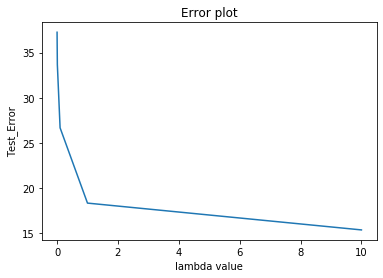

In [92]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in clf.cv_results_['mean_test_score']]
plt.plot(C_range, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [93]:
#FITTING THE MODEL
w2v_avg_model = LogisticRegression(penalty ='l2',C = 10,random_state = 42)
w2v_avg_model.fit(vectors_for_avg_w2v[1],y_train)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### <font color="red">PERFORMANCE METRICS.

In [94]:
pred_w2v = w2v_avg_model.predict(vectors_for_avg_w2v[3])

#train test accuracy
train_acc_w2v2 = w2v_avg_model.score(vectors_for_avg_w2v[0],Y_train.ravel())
test_acc_w2v2 = w2v_avg_model.score(vectors_for_avg_w2v[3],y_test)

#train test ROC value
y_scores_w2v_train = w2v_avg_model.predict_proba(vectors_for_avg_w2v[1])
fpr,tpr,thresholds = roc_curve(y_train,y_scores_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr,tpr)

y_scores_w2v_test = w2v_avg_model.predict_proba(vectors_for_avg_w2v[3])
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre2 = precision_score(y_test, pred_w2v) * 100
rec2 = recall_score(y_test, pred_w2v) * 100
f12 = f1_score(y_test, pred_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_w2v2*100))
print("\nTest accuracy=%e%% "% (test_acc_w2v2*100))
print("\nTrain ROC value=%f"% (roc_auc))
print("\nTest ROC value=%f"% (roc_auc_1))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))




Train accuracy=60.333333%

Test accuracy=5.048889e+01% 

Train ROC value=0.550272

Test ROC value=0.922319

precision=0.000000%

recall=0.000000%

F1-Score=0.000000%


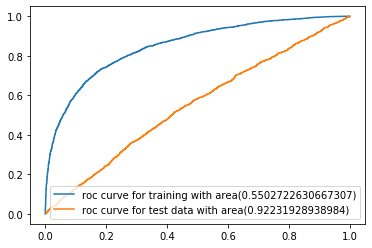

In [95]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_1))
plt.legend(loc="lower right")
plt.show()

In [96]:
#Confusion Matrix
pred_avg_w2v = w2v_avg_model.predict(vectors_for_avg_w2v[3])    
from sklearn.metrics import confusion_matrix
cm_avg_w2v = confusion_matrix(y_test, pred_avg_w2v)
cm_avg_w2v

array([[2272,    0],
       [2228,    0]], dtype=int64)

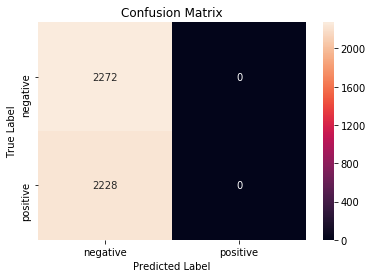

In [97]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_avg_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### OBSERVATIONS:
1. The FPR value is very high while the TNR value is zero.<br>
2. The ROC value for test data is approx 0.5.Hence, The W2V model is not good enough for classification.

In [98]:
from prettytable import PrettyTable
x = PrettyTable()


reg2 = 'L2'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]




err2_train = np.around(100 - train_acc_w2v2*100, decimals = 2)
err2_test =  np.around(100 - test_acc_w2v2*100, decimals = 2)
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)


x.add_row([cv,reg2,best_c,err2_train,err2_test,pre2,rec2,f12])

print(x)

+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
| Grid |      L2     |    10   |     39.67      |     49.51     |     0.0      |    0.0    |     0.0     |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+


The TRAIN and TEST error is very high.

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [99]:
# CONVERTING TEST DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_test_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [100]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_test_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [03:21<00:00, 22.34it/s]


In [101]:
# CONVERTING TRAIN DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [102]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_train_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 7350/7350 [07:30<00:00, 16.33it/s]


In [103]:
# CONVERTING CROSS VALIDATION DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_cv_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [104]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_crossval_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_cv_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_crossval_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3150/3150 [02:15<00:00, 23.16it/s]


In [105]:
# CONVERTING CROSS VALIDATION DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [106]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 10500/10500 [13:51<00:00, 12.63it/s]


In [107]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range)
clf=GridSearchCV(LogisticRegression(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_tfidf_w2v,y_train)
probcv=clf.predict_proba(x_crossval_tfidf_w2v)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_tfidf_w2v)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c=clf.best_params_['C']
print("The best c value is ",best_c)

The best c value is  0.001


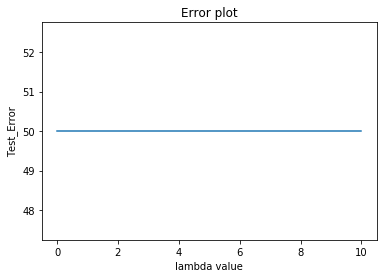

In [108]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in clf.cv_results_['mean_test_score']]
plt.plot(C_range, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [109]:
#fitting the model
w2v_tfidf_model = LogisticRegression(penalty ='l2',C = 0.0001,random_state = 42)
w2v_tfidf_model.fit(X_train_tfidf_w2v,Y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
pred_w2v = w2v_tfidf_model.predict(x_test_tfidf_w2v)

#train test accuracy
train_acc_w2v2 = w2v_tfidf_model.score(X_train_tfidf_w2v,Y_train.ravel())
test_acc_w2v2 = w2v_tfidf_model.score(x_test_tfidf_w2v,y_test)

#train test ROC value
y_scores_w2v_train = w2v_tfidf_model.predict_proba(x_train_tfidf_w2v)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr,tpr)

y_scores_w2v_test = w2v_tfidf_model.predict_proba(x_test_tfidf_w2v)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre2 = precision_score(y_test, pred_w2v) * 100
rec2 = recall_score(y_test, pred_w2v) * 100
f12 = f1_score(y_test, pred_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_w2v2*100))
print("\nTest accuracy=%e%% "% (test_acc_w2v2*100))
print("\nTrain ROC value=%f"% (roc_auc))
print("\nTest ROC value=%f"% (roc_auc_1))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))




Train accuracy=50.209524%

Test accuracy=4.951111e+01% 

Train ROC value=0.500000

Test ROC value=0.922319

precision=49.511111%

recall=100.000000%

F1-Score=66.230678%


#### <font color="red"> PERFORMANCE METRICS

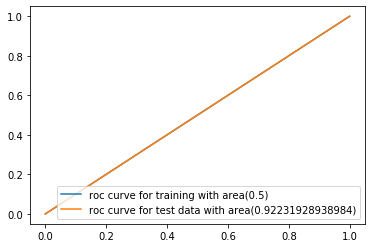

In [111]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_1))
plt.legend(loc="lower right")
plt.show()

In [112]:
#Confusion Matrix
pred_tfidf_w2v = w2v_avg_model.predict(x_test_tfidf_w2v)    
from sklearn.metrics import confusion_matrix
cm_tfidf_w2v = confusion_matrix(y_test, pred_tfidf_w2v)
cm_tfidf_w2v

array([[2272,    0],
       [2228,    0]], dtype=int64)

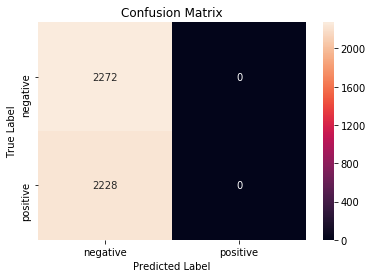

In [113]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tfidf_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
from prettytable import PrettyTable
x = PrettyTable()


reg2 = 'L2'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]




err2_train = np.around(100 - train_acc_w2v2*100, decimals = 2)
err2_test =  np.around(100 - test_acc_w2v2*100, decimals = 2)
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)


x.add_row([cv,reg2,best_c,err2_train,err2_test,pre2,rec2,f12])

print(x)

+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
| Grid |      L2     |  0.001  |     49.79      |     50.49     |    49.51     |   100.0   |    66.23    |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+


### OBSERVATION:
1.The TPR value for above model is 0. Hence. we can conclude that our model is not good enough for classification.

# CONCLUSION:
1. The BOW and TFIDF based model is working well for classification. 
2. The features are non-collinear for BOW as well as TFIDF based on the median value of percentage_change_vector.
3. The optimal value for models can be visualized using ERROR PLOT(plotted for each model above)


## CONSIDERING LENGTH OF REVIEWS AS FEATURE.

In [115]:
final.shape

(87773, 11)

In [116]:
#Creating a list of lengths of all reviews
length_of_reviews = []
for i in preprocessed_reviews:
    length_of_reviews.append(len(i))
print(len(length_of_reviews))    

87773


In [117]:
print(length_of_reviews[:10])

[162, 72, 406, 209, 277, 84, 68, 495, 255, 196]


In [118]:
# adding length of reviews in amazon food fine reviews dataset
final["length_of_reviews"] = length_of_reviews

In [119]:
final.shape

(87773, 12)

In [120]:
#Randomly taking 50000 points from each positive and negative reviews due to less memory capacity
data_pos_length = final[final["Score"] ==1.0].sample(n = 800)
data_neg_length= final[final["Score"] ==0.0].sample(n = 800)


#concatenating the positive and negative reviews data 
final_length_data= pd.concat([data_pos_length,data_neg_length],axis=0)

print(final_length_data.shape)
final_length_data.head()


(1600, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews
72133,78520,B000BQVS0E,A28NKYVADM4ZNH,catherine,0,0,1,1288915200,"Excellent ""milk ""substitute for toddler who ca...",Daughter has dairy/soy issues and we were so h...,daughter dairy soy issues happy found breastfe...,209
93931,102117,B001HX59QO,A6DJ659L9HA7C,John P. Finley,1,1,1,1264550400,Minty and Refreshing - Excellent K-Cup!,"This K-Cup provides a VERY MINTY, refreshing t...",k cup provides minty refreshing taste even lar...,109
28713,31315,B000TZ70TA,A3PWGSBTJ2J52G,"H. Laurin ""always looking for good deals""",0,0,1,1221696000,"GREAT food, my dog Loves it!","I adopted a dog in Oct. 2007, and started tryi...",adopted dog oct started trying different foods...,791
274,301,B001UJEN6C,A297HRGWRID7I6,Mariza R Barnes,0,0,1,1347321600,The Best,I have tried other energy shots and this one i...,tried energy shots one one really makes feel g...,149
73897,80408,B0019955O2,A3LS0SWE5K1UAL,Betsy Crites,0,0,1,1280966400,I won't drink anything else,I find Larry's decaf espresso as good or bette...,find larry decaf espresso good better anything...,243


#### NOTE:
1.The length of review is a Numerical feature. So, To deal with, we consider that the length of reviews are normally distributed.
2.We will plot pdf for both positive and negative reviews. Then, we will calculate the probability for each query point of both classes using pdf.

counts are [2.42508496e-03 4.55668829e-04 1.15848007e-04 5.02008032e-05
 1.54464010e-05 1.15848007e-05 3.86160025e-06 7.72320049e-06
 0.00000000e+00 3.86160025e-06]
***********************************************************
bin_edges are [  27.   350.7  674.4  998.1 1321.8 1645.5 1969.2 2292.9 2616.6 2940.3
 3264. ]
***********************************************************


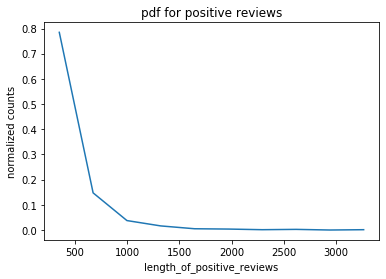

In [121]:
counts,bin_edges = np.histogram(data_pos_length["length_of_reviews"],bins=10,density=True)
pdf = counts/counts.sum()
cdf = np.cumsum(pdf)
print("counts are",counts)
print("***********************************************************")
print("bin_edges are",bin_edges)
print("***********************************************************")

plt.plot(bin_edges[1:],pdf)
#plt.plot(bin_edges[1:],cdf)
plt.ylabel("normalized counts")
plt.xlabel("length_of_positive_reviews")
plt.title("pdf for positive reviews")
plt.show()

counts are [2.30483716e-03 1.53855364e-03 5.38793103e-04 2.39463602e-04
 7.18390805e-05 4.78927203e-05 1.79597701e-05 5.98659004e-06
 5.98659004e-06 1.79597701e-05]
***********************************************************
bin_edges are [   0.   208.8  417.6  626.4  835.2 1044.  1252.8 1461.6 1670.4 1879.2
 2088. ]
***********************************************************


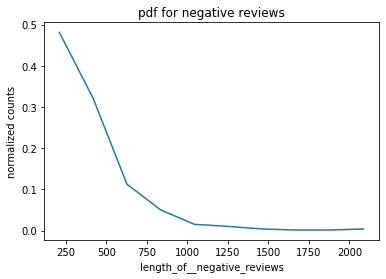

In [122]:
counts,bin_edges = np.histogram(data_neg_length["length_of_reviews"],bins=10,density=True)
pdf = counts/counts.sum()
cdf = np.cumsum(pdf)
print("counts are",counts)
print("***********************************************************")
print("bin_edges are",bin_edges)
print("***********************************************************")

plt.plot(bin_edges[1:],pdf)
#plt.plot(bin_edges[1:],cdf)
plt.ylabel("normalized counts")
plt.xlabel("length_of__negative_reviews")
plt.title("pdf for negative reviews")
plt.show()

### OBSERVATION:
1.The pdf of both the classes are not distributed normally.<BR>
2.It seems that positive and negative reviews are having power law distribution.

### CONCLUSION:
1.Using length of reviews as a feature is not so helpful because these are not following any of these distribiutions-normal, binomial, and poisson's. It's difficult and lengthy to train a probablistic model which is not following above mentioned distributions.<BR>
2.There can be another method to calculate probablities- using power law transformation which transform power law distribution to normal distribution. But it's our assumption that above pdf is following power law distribution. Using it simply will not give a well working model as we are fully relying on assumptions.

## *******CONSIDERING SUMMARY AS FEATURES.*****

In [123]:
print(final.shape)
print("*************************************************")

##adding cleaned_text column to the final dataframe
final["cleaned_summary"] = preprocessed_reviews_summary

print(final.shape)
print("*************************************************************************************")
#checking if any missing values is present in the reviews.
final = final.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

print(final.shape)

final.head()

(87773, 12)
*************************************************
(87773, 13)
*************************************************************************************
(87773, 13)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162,made china
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72,dog lover delites
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406,one fruitfly stuck
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209,not work not waste money
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277,big rip


In [124]:
#Randomly taking 40000 points from each positive and negative reviews due to less memory capacity
data_pos_summ = final[final["Score"] ==1.0].sample(n = 800)
data_neg_summ = final[final["Score"] ==0.0].sample(n = 800)


#concatenating the positive and negative reviews data 
final_cleaned_summ_data = pd.concat([data_pos_summ,data_neg_summ],axis=0)

print(final_cleaned_summ_data.shape)
final_cleaned_summ_data.head()

(1600, 13)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
20420,22309,B0041GHV8I,A1XMB52F1KZ4PK,Allison C,0,0,1,1329609600,What Peas Are Supposed to Be,This is an amazing product. I've spent so much...,amazing product spent much time trying find de...,307,peas supposed
21671,23726,B0013NUGDE,A215WH6RUDUCMP,Shilom,1,1,1,1268438400,Tasty!,"We all have our vices, mine has always been ch...",vices mine always chips specifically bettermad...,477,tasty
23108,25286,B0064A72UG,A2YM3KILJ1G0YJ,Jason,7,7,1,1324166400,EXACTLY what you'd expect,How in the world do you review a gummy worm? ...,world review gummy worm well think expectation...,507,exactly would expect
84284,91701,B000EZOKX4,A1DZ5OW6RCLHDW,bobdog314,0,0,1,1343865600,love love love,I would like to start off by saying....i have ...,would like start saying week old bengal kitten...,407,love love love
11895,12957,B000ET93N2,A16J5HGMGX5LWM,Enovative Solutions Inc Stephenson,0,0,1,1265846400,Almost perfect crackers,Being the lone Celiac in the crowd makes for c...,lone celiac crowd makes challenging entertaini...,780,almost perfect crackers


In [125]:
#time based splitting of the data
#converting time to date and time
final_cleaned_summ_data["Time"] = pd.to_datetime(final_cleaned_summ_data["Time"],unit="s")
final_cleaned_summ_data = final_cleaned_summ_data.sort_values(by = "Time")
final_cleaned_summ_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,length_of_reviews,cleaned_summary
94382,102594,B0000D9N6V,A28ECE800BV42W,"""bungfritz""",5,5,1,2004-02-05,Best example of a blue cheese I've ever tried,And that is no exagerration! Roaring 40's Blu...,no exagerration roaring blue wonderful mixture...,304,best example blue cheese ever tried
14096,15390,B0002IMRTC,ALKOHQH542KO,G. Elliott,5,15,1,2004-07-20,Peet says it's good.,So it must be good. He never lies to me. Eve...,must good never lies even skizip likes drinks ...,71,peet says good
16217,17710,B0051OQ23E,A1LBU1GH9H5F0P,"Y. Fung ""ambivalence""",3,3,1,2005-07-01,Best cookie in the world!,If you love the taste of caramel and the crisp...,love taste caramel crisp crunch thin cookie no...,82,best cookie world
1984,2165,B000N5XCPM,A3NGLRNUFTTKTD,L. E. Thomas,2,2,1,2005-12-28,We Love Grammy's!,We adopted an 8-year-old Dalmatian earlier thi...,adopted dalmatian earlier year heard lots caut...,258,love grammy
79074,85979,B000CMKPDI,A25UOSQ1II09QA,"Curt A. Meyers ""Boilerbots""",35,66,0,2006-06-01,Somebody better check their specifications,"Last time I checked, water based products such...",last time checked water based products poop no...,177,somebody better check specifications


In [126]:
X_summ = np.array(final_cleaned_summ_data.loc[:,["cleaned_summary"]])
Y_summ = np.array(final_cleaned_summ_data.loc[:,["Score"]])

#train_test_split of the data
X_train,x_test,Y_train,y_test = model_selection.train_test_split(X_summ,Y_summ,test_size = 0.3,random_state= 42)

x_train , x_cv,y_train,y_cv = model_selection.train_test_split(X_train,Y_train,test_size =0.3,random_state = 42)



In [127]:
#converting all into dataframes 
X_train = pd.DataFrame(X_train,columns = ["summary"])
x_train = pd.DataFrame(x_train,columns = ["summary"])
x_cv = pd.DataFrame(x_cv,columns =["summary"])
x_test = pd.DataFrame(x_test,columns =["summary"])
#y_train = pd.DataFrame(y_train,columns =["scores"])
#y_cv = pd.DataFrame(y_cv,columns =["scores"])


count_vec = CountVectorizer()
count_vec.fit(x_train["summary"])
X_train_bow = count_vec.transform(X_train["summary"])
x_train_bow = count_vec.transform(x_train["summary"])
x_cv_bow = count_vec.transform(x_cv["summary"])
x_test_bow = count_vec.transform(x_test["summary"])
#X_train = count_vec.transform(X_train["text"])

In [128]:
print(len(count_vec.get_feature_names()))
print(X_train_bow[1].toarray())

1057
[[0 0 0 ... 0 0 0]]


#### HYPERPARAMETER TUNING: <font color="red">GRIDSEARCH CV.

In [129]:
#performing cross validation using gridsearchcv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
C_range = [0.001,0.01,0.1,1,10]
parameters=dict(C = C_range)
clf=GridSearchCV(LogisticRegression(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_bow,y_train)
probcv=clf.predict_proba(x_cv_bow)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_bow)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
best_c=clf.best_params_['C']
print("The best c value is ",best_c)

The best c value is  0.1


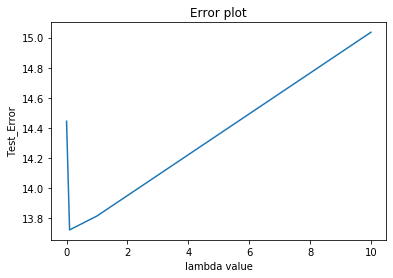

In [130]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in clf.cv_results_['mean_test_score']]
plt.plot(C_range, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [131]:
#now we will fit wth the model
bow_model = LogisticRegression(penalty ='l2',C = 1,random_state = 42)
bow_model.fit(X_train_bow,Y_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
pred_bow = bow_model.predict(x_test_bow)

#train test accuracy
train_acc_bow2 = bow_model.score(X_train_bow,Y_train.ravel())
test_acc_bow2 = bow_model.score(x_test_bow,y_test)

#train test ROC value
y_scores_w2v_train = bow_model.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr,tpr)

y_scores_w2v_test = bow_model.predict_proba(x_test_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre2 = precision_score(y_test, pred_bow) * 100
rec2 = recall_score(y_test, pred_bow) * 100
f12 = f1_score(y_test, pred_bow) * 100


print("\nTrain accuracy=%f%%"% (train_acc_bow2*100))
print("\nTest accuracy=%e%% "% (test_acc_bow2*100))
print("\nTrain ROC value=%f"% (roc_auc))
print("\nTest ROC value=%f"% (roc_auc_1))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))




Train accuracy=93.125000%

Test accuracy=7.875000e+01% 

Train ROC value=0.865417

Test ROC value=0.922319

precision=84.158416%

recall=70.833333%

F1-Score=76.923077%


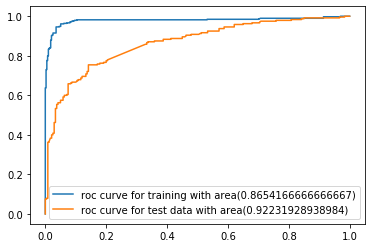

In [134]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_1))
plt.legend(loc="lower right")
plt.show()

In [135]:
#Confusion Matrix
pred_bow = bow_model.predict(x_test_bow)    
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
cm_bow

array([[208,  32],
       [ 70, 170]], dtype=int64)

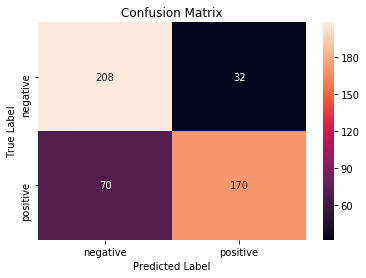

In [136]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [137]:
from prettytable import PrettyTable
x = PrettyTable()


reg2 = 'L2'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]




err2_train = np.around(100 - train_acc_bow2*100, decimals = 2)
err2_test =  np.around(100 - test_acc_bow2*100, decimals = 2)
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)


x.add_row([cv,reg2,best_c,err2_train,err2_test,pre2,rec2,f12])

print(x)

+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+
| Grid |      L2     |   0.1   |      6.88      |     21.25     |    84.16     |   70.83   |    76.92    |
+------+-------------+---------+----------------+---------------+--------------+-----------+-------------+


### OBSERVATIONS:
1. The TPR and TNR value is high as compared to FPR and FNR value.<br>
2. The ROC value for test data is greater than 0.5 (i.e 0.85). Hence, our model is sensible and good for classification.
3. The Precision, Recall and F_1 score is high. Hence, model is predicting more correct responses.

### <FONT COLOR="RED"> PERTUBATION TEST

In [138]:
pre_w = bow_model.coef_[0]
pre_w += 10**-6

X_train_bow = X_train_bow.toarray()
X_train_bow = X_train_bow.astype(float)
noise_data = X_train_bow
noise_data +=0.01

clf = LogisticRegression(C = best_c)
clf.fit(noise_data,Y_train)

new_w = clf.coef_[0]
new_w +=10**-6




In [139]:
#finding the change in percentage value 
def Weight_change(Pre_weights,New_weights):
    per_cng=[]
    for i in range(len(pre_w)):
        per = a[i]*100/pre_w[i]
        per_cng.append(per)
    return per_cng
    
# to calculate percentage change for both weights
a = new_w - pre_w  
per_change = Weight_change(pre_w,new_w)

In [140]:
import math as m
per_change = abs(np.array(per_change))
print(np.median(per_change))

81.46074119210166


In [141]:
#extracting all features name obtained from tfidf count vectorizer.
f = count_vec.get_feature_names()
f = np.array(f)
print(f.shape)

#extracting coefficients from logistic regression model(i.e - The values of w and b)
cof = bow_model.coef_[0]
cof= np.array(cof)
cof.shape
cof = cof.T
cof.shape

##creating a dataframe for features and it's corresponding weight vector
weight_vector = pd.DataFrame({'weight':cof,'feature':f})
weight_vector.head()

(1057,)


,weight,feature
0,0.141337,absolutely
1,0.291793,actually
2,-0.168570,add
3,0.677204,added
4,0.456183,addicting


In [142]:
##creating a dataframe for featutres and itd corresponding weight vector
weight_vector = pd.DataFrame({'weight':cof,'feature':f})
weight_vector.head()

,weight,feature
0,0.141337,absolutely
1,0.291793,actually
2,-0.168570,add
3,0.677204,added
4,0.456183,addicting


In [143]:
# to get top 20 positive and negative features 
weight_vector = weight_vector.sort_values("weight", axis = 0 ,ascending = False, kind = 'quicksort',na_position = 'last')
weight_vector.head()

,weight,feature
415,2.549691,great
72,2.408562,best
552,2.040175,love
242,2.022407,delicious
49,1.936138,awesome


In [144]:
# to get top 20 positive and negative features 
print(weight_vector.head(20).to_string(index=False))
#weight_vector.iloc[0:10,0:2]

   weight    feature
 2.549691      great
 2.408562       best
 2.040175       love
 2.022407  delicious
 1.936138    awesome
 1.728895  excellent
 1.665090   favorite
 1.651734      yummy
 1.574994    perfect
 1.569039    amazing
 1.461031      tasty
 1.424858      loves
 1.223532        yum
 1.201088    without
 1.173377       good
 1.133819         go
 1.129561  fantastic
 1.100114       cats
 1.032497      loved
 1.020275        bay


In [145]:
# to get top 20 positive and negative features 
print(weight_vector.tail(20).to_string(index=False))
#weight_vector.iloc[0:10,0:2]

   weight         feature
-0.822177           salty
-0.846910         pricing
-0.847060      aftertaste
-0.854059           small
-0.884774  disappointment
-0.902467            less
-0.923261      disgusting
-0.943223          ruined
-1.003356          beware
-1.008053           gross
-1.090389           stale
-1.116475             way
-1.147641           awful
-1.178827   disappointing
-1.260458        horrible
-1.269182        terrible
-1.374041           worst
-1.403759            yuck
-1.586415    disappointed
-2.422380             not


## CONCLUSION
Using either text or summary as a feature for classification, the BOW and TFIDF are working well and giving approximately same result for performances metrices. So, any of the feature can bve used for classification.

In [ ]:
!jupyter nbconvert --to html Logistic_regression_assignment.ipynb